<a href="https://colab.research.google.com/github/gustafbjurstam/ML-retreat-tekmek-2025/blob/main/unsupervised-learning-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PCA and unsupervised learning

In this lesson we will be learning about *unsupervised learning*. This means that the computer has to work something out about data without knowing the correct answer to any data points a priori. Generally we say that there are three broad areas, clustering, anomaly detection, and dimensionality reduction.

The methods we will examine in each category are

- Dimensionality reduction
    - Principal Component Analysis (PCA)
    - Sparse PCA
- Clustering / Unsupervised classification
    - K-means
    - Hierarchical clustering with dendrograms
    - Graph based clustering
        - ɛ-neigbourhood
        - k-Nearest-Neighbours
        - Spectral clustering
- Anomaly detection
    - k-Nearest-Neighbours
    - One-Class Support Vector Machines

test.

## Dimensionality reduction
High‑fidelity measurements in engineering—whether velocity fields, pressure traces, or multichannel strain gauges—arrive as vectors with hundreds or even thousands of degrees of freedom, yet the underlying behaviour is often governed by just a handful of dominant patterns.  **Dimensionality reduction** is the process of discovering those low‑rank coordinates.  By projecting the data onto a smaller subspace we obtain a more tractable description, filter measurement noise, and expose latent structure that would be invisible in the raw variables.  Crucially, this is done *without* requiring any labels: the algorithm infers which directions matter solely from statistical regularities in the snapshots themselves.

While every method we study shares that goal, they differ in the assumptions they impose.  Classical principal‑component analysis (PCA) seeks orthogonal directions of maximal variance and produces dense modes that blend information from all sensors; Sparse PCA adds an explicit sparsity penalty so each mode depends on only a few physical locations, enhancing interpretability at the cost of a slight loss in captured energy.  Both remain linear, keeping the mathematics transparent and the computations fast enough for real‑time applications—a useful counter‑point to the non‑linear and probabilistic tools that follow later in the course.

---
Let us now introduce the data set we will be using to study the two methods mentioned in the introduction.

The dataset is a time-series of a synthetic 2D flow field, generated by superimposing a multi-scale, stochastic procedural noise field onto a periodic, incompressible Double Gyre base flow. The final scalar values represent the speed of the combined velocity field on a regular spatial grid.

* **Base Flow:** A time-periodic, incompressible velocity field from the analytical Double Gyre model, representing a large-scale coherent structure.
* **Perturbation Field:** A superimposed, synthetic field generated using multi-scale procedural noise (Fractional Brownian Motion) to serve as a complex, high-dimensional background.
* **Output Data:** A time-series of scalar snapshots representing the flow speed ($|\mathbf{u}|$) of the combined fields on a uniform Cartesian grid.


In [ ]:
#@title Generator functions run but no need to see
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # Import for Colab display
import time

# --- (Self-contained noise generation function) ---
def generate_perlin_fbm(shape, res, octaves=4, persistence=0.5, lacunarity=2.0, seed=0):
    """
    Generates a 3D Fractional Brownian Motion field using vectorized Perlin noise.
    No external libraries needed beyond NumPy.
    """
    rng = np.random.default_rng(seed)
    noise = np.zeros(shape)
    frequency = 1.0
    amplitude = 1.0

    for _ in range(octaves):
        # Create grid points and random gradients
        # FIX IS HERE: Ensure the resolution for the noise grid is at least 1,
        # which makes the gradient grid size at least 2.
        t_res, y_res, x_res = (max(1, int(r * frequency)) for r in res)

        grid_shape = (t_res + 1, y_res + 1, x_res + 1)

        gradients = rng.uniform(-1, 1, size=(*grid_shape, 3))
        gradients /= np.linalg.norm(gradients, axis=-1, keepdims=True)

        # Create coordinates for each point in the output shape
        t_coords, y_coords, x_coords = np.meshgrid(
            np.linspace(0, t_res, shape[0], endpoint=False),
            np.linspace(0, y_res, shape[1], endpoint=False),
            np.linspace(0, x_res, shape[2], endpoint=False),
            indexing='ij'
        )

        # Calculate grid indices and local coordinates
        t0, y0, x0 = t_coords.astype(int), y_coords.astype(int), x_coords.astype(int)
        t, y, x = t_coords - t0, y_coords - y0, x_coords - x0

        # Smoothstep function for interpolation weights
        def fade(t): return t * t * t * (t * (t * 6 - 15) + 10)
        wt, wy, wx = fade(t), fade(y), fade(x)

        # Calculate dot products with gradients at the 8 corners of the cube
        noise_val = np.zeros(shape)
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    grad = gradients[t0 + i, y0 + j, x0 + k]
                    dot_prod = grad[..., 0] * (t - i) + grad[..., 1] * (y - j) + grad[..., 2] * (x - k)

                    # Interpolate
                    interp_weight = (wt if i == 1 else 1 - wt) * \
                                    (wy if j == 1 else 1 - wy) * \
                                    (wx if k == 1 else 1 - wx)
                    noise_val += dot_prod * interp_weight

        noise += noise_val * amplitude
        amplitude *= persistence
        frequency *= lacunarity

    return noise

def generate_perturbed_gyre_data(
    grid_res=20,       # Resolution of the spatial grid
    n_snapshots=200,   # Number of time steps
    A=0.1,             # Gyre velocity magnitude
    epsilon=0.25,      # Gyre oscillation amplitude
    omega=2 * np.pi / 10, # Gyre oscillation frequency

    # --- Perturbation Field Parameters ---
    perturbation_strength=0.4,
    noise_scale=12.0,
    octaves=4,
    persistence=0.5,
    lacunarity=2.0,
    time_scale=0.5
):
    """
    Generates a Double Gyre dataset with a synthesized stochastic perturbation field.
    """
    # 1. Define Spatial and Temporal Grid
    x_points = np.linspace(0, 2, grid_res * 2); y_points = np.linspace(0, 1, grid_res)
    xx, yy = np.meshgrid(x_points, y_points)
    t_space = np.linspace(0, 20, n_snapshots)

    # 2. Generate the entire 3D (time, y, x) noise fields in one go
    shape_3d = (n_snapshots, grid_res, grid_res * 2)
    res_3d = (t_space.size*time_scale/10, y_points.size*noise_scale/100, x_points.size*noise_scale/100)

    print("Generating 3D noise field for u_perturb...")
    u_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=42)
    print("Generating 3D noise field for v_perturb...")
    v_perturb_3d = generate_perlin_fbm(shape_3d, res_3d, octaves, persistence, lacunarity, seed=99)

    snapshot_data = []
    for i, t in enumerate(t_space):
        # 3. Calculate base gyre flow for the current time step
        a_t = epsilon * np.sin(omega * t); b_t = 1 - 2 * epsilon * np.sin(omega * t)
        f_x_t = a_t * xx**2 + b_t * xx; df_dx = 2 * a_t * xx + b_t
        u_gyre = -np.pi * A * np.sin(np.pi * f_x_t) * np.cos(np.pi * yy)
        v_gyre = np.pi * A * np.cos(np.pi * f_x_t) * np.sin(np.pi * yy) * df_dx

        # 4. Combine the base flow and the perturbation
        u_total = u_gyre + perturbation_strength * A * u_perturb_3d[i]
        v_total = v_gyre + perturbation_strength * A * v_perturb_3d[i]
        speed = np.sqrt(u_total**2 + v_total**2)
        snapshot_data.append(speed.flatten())

    return np.array(snapshot_data), xx, yy

def animate_flow(data_matrix, xx, yy, title_prefix, vmin, vmax):
    """Creates a matplotlib animation object for the given flow data."""
    fig, ax = plt.subplots(figsize=(10, 5))
    grid_shape = xx.shape
    initial_frame = data_matrix[0, :].reshape(grid_shape)
    quad_mesh = ax.pcolormesh(xx, yy, initial_frame, cmap='inferno', vmin=vmin, vmax=vmax, shading='gouraud')
    fig.colorbar(quad_mesh, ax=ax, label='Flow Speed')

    def update(frame):
        ax.cla()
        speed_field = data_matrix[frame, :].reshape(grid_shape)
        ax.pcolormesh(xx, yy, speed_field, cmap='inferno', vmin=vmin, vmax=vmax, shading='gouraud')
        ax.set_title(f"{title_prefix} (Frame: {frame})")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal', 'box')

    ani = FuncAnimation(fig, update, frames=data_matrix.shape[0], interval=50, blit=False)
    plt.close(fig)
    return ani

In [ ]:
# 1. Generate and visualise data
print("Generating Perturbed Double Gyre data...")
X_speed, xx, yy = generate_perturbed_gyre_data()

# Set shared color limits for a fair comparison
vmin, vmax = 0, np.percentile(X_speed, 99.5)

print("Creating animation for the original flow...")
ani_original = animate_flow(X_speed, xx, yy, "Original Perturbed Flow", vmin, vmax)

# Display the animations in the Colab notebook
# The animations will appear as playable videos in the output cells.
print("\n--- Original Flow Animation ---")
display(HTML(ani_original.to_html5_video()))




Generating Perturbed Double Gyre data...
Generating 3D noise field for u_perturb...
Generating 3D noise field for v_perturb...
Creating animation for the original flow...

--- Original Flow Animation ---


### Principal Component Analysis
Principal‑component analysis treats a zero‑centred data matrix $X\in\mathbb{R}^{N\times p}$ —each row a snapshot, each column a measured variable—as the empirical realisation of an underlying random vector and seeks an orthonormal basis that captures as much variance as possible in the first few directions.  If the sample covariance is $\Sigma = \tfrac{1}{N-1} X^{\mathsf T}X$, then for any unit vector $\mathbf{w}$ the variance of the projected data $X\mathbf{w}$ is $\mathbf{w}^{\mathsf T}\Sigma\mathbf{w}$.  Maximising this quadratic form under the unit‑norm constraint leads, via the Rayleigh quotient, to the eigenproblem

$$
\Sigma\mathbf{w}_1 = \lambda_1\mathbf{w}_1,\qquad
\lambda_1=\max_{\lVert\mathbf{w}\rVert=1}\mathbf{w}^{\mathsf T}\Sigma\mathbf{w}.
$$

Successive directions are obtained by iterating on $\Sigma$ subject to orthogonality, giving an ordered set of eigenpairs $ \{(\lambda_k,\mathbf{w}_k)\}_{k=1}^{p}$ with $ \lambda_1\ge \lambda_2\ge\cdots\ge\lambda_p$.  The projection of $X$ onto the first $r$ eigenvectors, $Z_r=X W_r$ with $W_r=[\mathbf{w}_1\,\dots\,\mathbf{w}_r]$, therefore retains the largest possible fraction $\sum_{k=1}^{r}\lambda_k / \sum_{k=1}^{p}\lambda_k$ of the total variance among all $r$-dimensional orthonormal subspaces.

The same result emerges from a complementary viewpoint: low‑rank reconstruction.  Writing $\hat X_r = Z_r W_r^{\mathsf T}$ and measuring the error with the Frobenius norm, PCA solves

$$
\min_{\operatorname{rank}(\hat X)\le r} \lVert X - \hat X\rVert_F
    \quad\Longrightarrow\quad \hat X_r = U_r S_r V_r^{\mathsf T},
$$

where $X = U S V^{\mathsf T}$ is the singular‑value decomposition and $U_r, S_r, V_r$ retain only the first $r$ singular triplets.  The Eckart–Young–Mirsky theorem states that this truncated SVD furnishes the unique linear approximant that minimises the mean‑squared reconstruction error; equivalently, PCA is the optimal rank‑$r$ projector in the Frobenius sense.

Because eigenvectors of $\Sigma$ and right singular vectors of $X$ coincide, PCA may be computed either via an eigen‑decomposition of the $p\times p$ covariance matrix or directly with an economy‑size SVD of $X$, the latter being numerically advantageous when $N < p$.  The resulting principal components—also called Karhunen‑Loève modes—form a deterministic, data‑adapted basis that diagonalises the empirical covariance; in practice just a handful of them often explain more than ninety per cent of the variance, enabling aggressive compression, noise filtering and, as we shall see in the example, the extraction of physically interpretable patterns from high‑dimensional measurements.

Performing PCA using SVD...


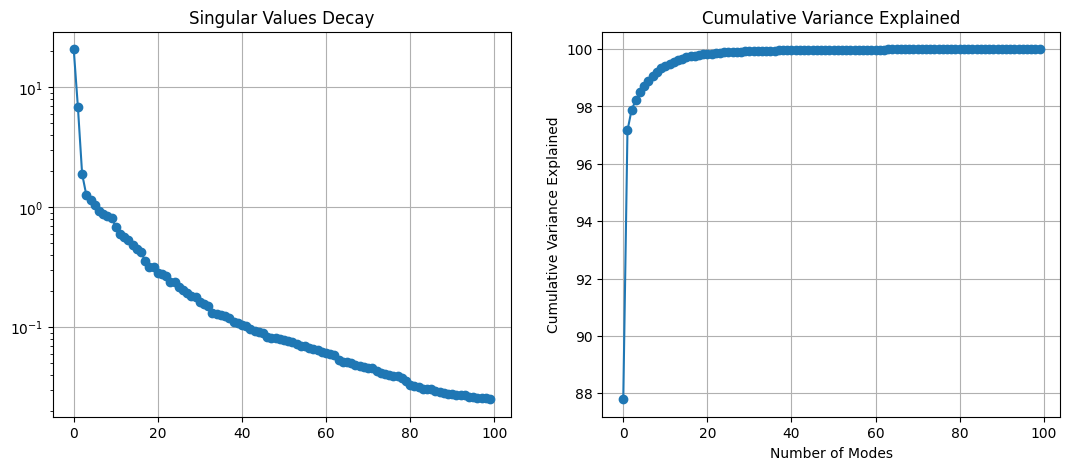

In [ ]:
# 2. Perform PCA
print("Performing PCA using SVD...")
X_mean = X_speed.mean(axis=0)
X_centered = X_speed - X_mean
U, S, VT = np.linalg.svd(X_centered, full_matrices=False)

# 3. Visualise the singular value decay, and cumulative variance explained
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.semilogy(S[:100], marker='o')
plt.title('Singular Values Decay')
plt.grid(visible=True)
plt.subplot(1, 2, 2)

# Cumulative percentage of variance explained
plt.plot(100*(np.cumsum(S**2) / np.sum(S**2))[:100], marker='o')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Variance Explained')
plt.grid(visible=True)
plt.show()


Visualising first 6 spatial modes...


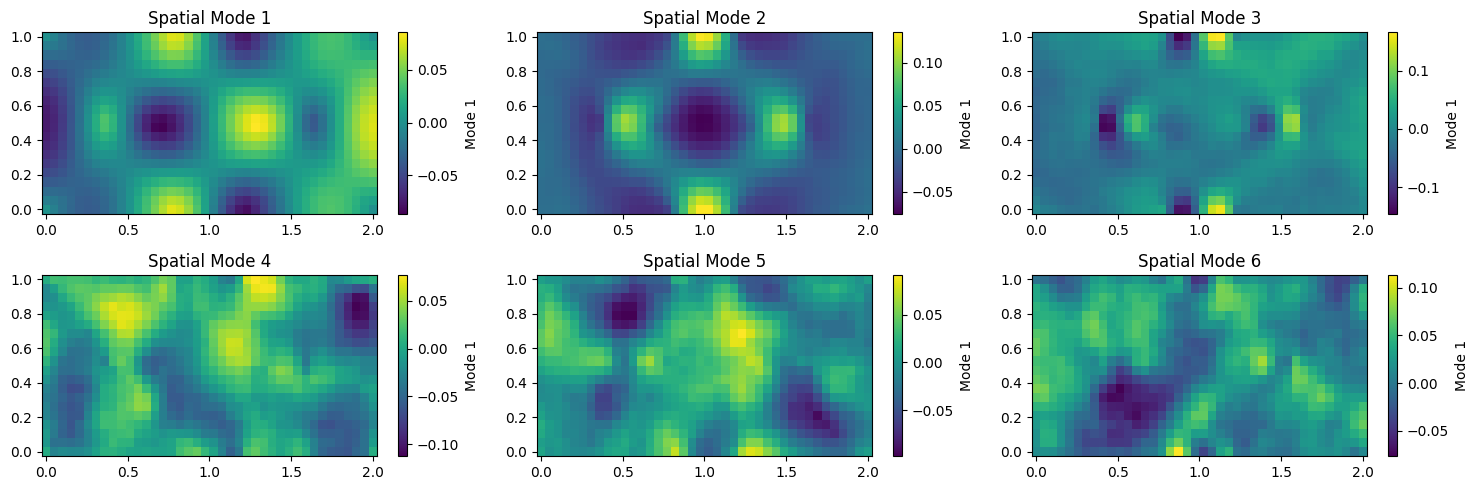

Visualising the temporal modes...


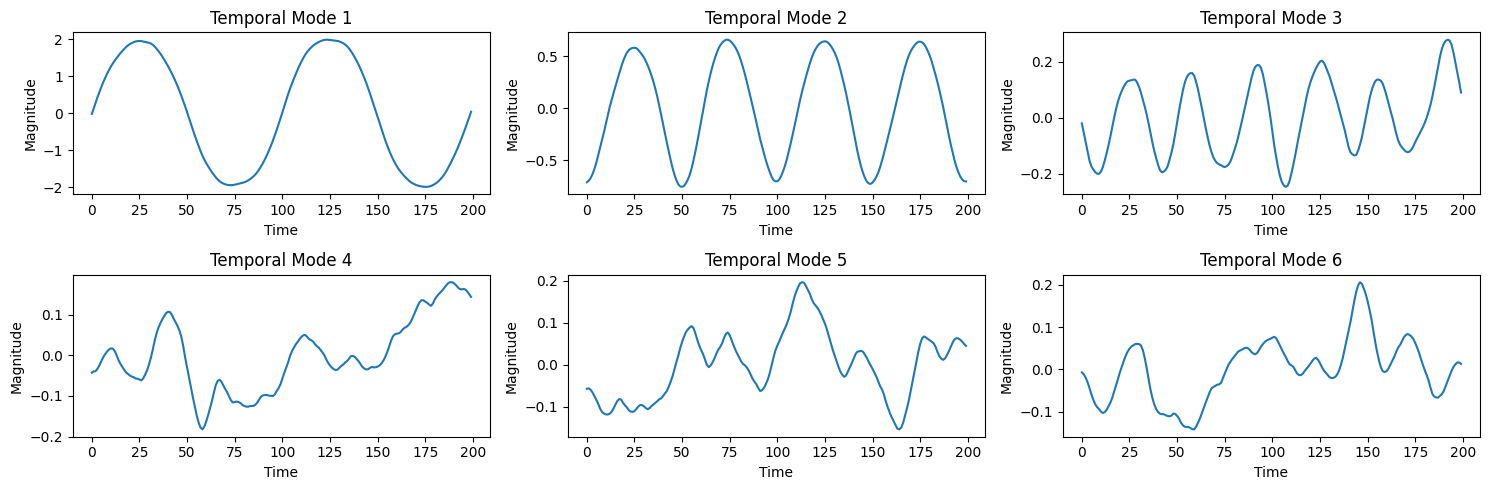

In [ ]:
# 4. Visualise first 6 spatial modes
print("Visualising first 6 spatial modes...")
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.pcolormesh(xx, yy, VT[i].reshape(xx.shape), shading='auto', cmap='viridis')
    plt.colorbar(label='Mode 1')
    plt.title(f'Spatial Mode {i+1}')
plt.tight_layout()
plt.show()

# 5. Visualise the temporal modes
print("Visualising the temporal modes...")
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(U[:,i]*S[i])
    plt.title(f'Temporal Mode {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


In [ ]:
# 6. Reconstruct Data
n_modes_to_reconstruct = 1 # You should choose how many modes to use in your reconstruction!!!
print(f"Reconstructing flow using {n_modes_to_reconstruct} modes...")
X_reconstructed = (U[:, :n_modes_to_reconstruct] * S[:n_modes_to_reconstruct]) @ VT[:n_modes_to_reconstruct, :] + X_mean

print(f"Cumulative variance explained:  {((np.cumsum(S[:n_modes_to_reconstruct]**2) / np.sum(S**2))[0])*100.2f}  %")

# Animate the reconstructed flow
print("Creating animation for the reconstructed flow...")
ani_reconstructed = animate_flow(X_reconstructed, xx, yy, f"Reconstructed Flow ({n_modes_to_reconstruct} Modes)", vmin, vmax)


print(f"\n--- Reconstructed Flow Animation (using {n_modes_to_reconstruct} modes) ---")
display(HTML(ani_reconstructed.to_html5_video()))

Reconstructing flow using 1 modes...
Cumulative variance explained:  87.79381519476303 %
Creating animation for the reconstructed flow...

--- Reconstructed Flow Animation (using 1 modes) ---


### Sparse PCA

Classical PCA compresses the data with dense, orthogonal loadings; **sparse PCA** keeps the linear structure but adds an ℓ₁ penalty so that *most* weights in every loading vector are driven to zero.  In scikit‑learn the model is written as a *dictionary‑learning* problem: for a centred data matrix $X\in\mathbb{R}^{N\times p}$ we seek a score matrix $U\in\mathbb{R}^{N\times r}$ and a component matrix $V\in\mathbb{R}^{r\times p}$ that solve

$$
\min_{U,V}\;
    \frac12\bigl\lVert X - U V\bigr\rVert_F^{2}
    \;+\;\alpha\sum_{k=1}^{r}\lVert V_{k\cdot}\rVert_{1}
    \;+\;\frac{\text{ridge\_}\alpha}{2}\,\lVert V\rVert_{F}^{2},
$$

where the first term measures reconstruction error, the second enforces sparsity row‑wise on the loadings $V_{k\cdot}$, and the optional ridge term stabilises ill‑conditioned problems.  The hyper‑parameter $\alpha\ge 0$ thus trades explained variance for interpretability: $\alpha\to 0$ recovers dense PCA, while larger $\alpha$ zeroes out ever more coefficients, localising each mode to a few physical features (pixels, sensors, grid points).

Optimisation proceeds by **block‑coordinate descent**: scikit‑learn alternates between (i) a least‑squares update of the scores $U$ given the current dictionary $V$, and (ii) a Lasso‑type soft‑thresholding update of each row of $V$ given the updated scores.  Convergence is guaranteed because each sub‑problem decreases the convex objective, although the global minimum is not unique and the final components are *not* constrained to be orthogonal or ordered by variance.  In practice we standardise the columns of $X$ before fitting, pick a modest rank $r$ (two in the cylinder‑flow demo), and tune $\alpha$ until each loading exhibits the desired degree of sparsity—often $80\!–\!95\%$ zeros while still retaining more than $90\%$ of the PCA energy.

The resulting sparse modes preserve the linear superposition property of PCA yet highlight *where* in space (or which sensors) dominate each direction, making them easier to interpret in an engineering setting.  Their scores $U$ can be used exactly like PCA coefficients—for clustering, anomaly detection, or low‑order modelling—subject only to the caveat that the scores are no longer uncorrelated because the loadings are no longer orthogonal.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize the Data
# This is the crucial new step.
print("Standardizing the data (mean=0, variance=1)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_centered)

# 2. Define Sparse PCA Parameters
# Now that the data is scaled, alpha can be much smaller and more intuitive.
n_sparse_modes = 3
alpha_regularization = 1.0 # A value around 1.0 is a good starting point for standardized data.

print(f"Applying Sparse PCA to the STANDARDIZED data...")

# 3. Create and Fit the Sparse PCA Model
spca = SparsePCA(
    n_components=n_sparse_modes,
    alpha=alpha_regularization,
    random_state=0,
    n_jobs=-1
)

# Fit on the newly scaled data
spca.fit(X_scaled)
print("Sparse PCA computed")



Standardizing the data (mean=0, variance=1)...
Applying Sparse PCA to the STANDARDIZED data...
Sparse PCA computed


Visualizing the sparse spatial modes...


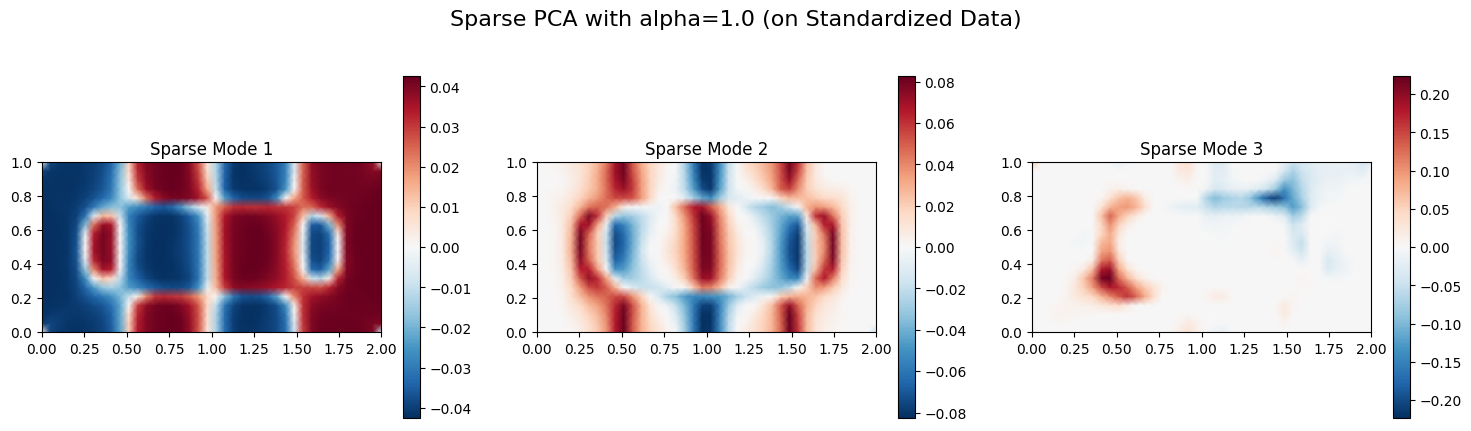

Visualizing the sparse temporal modes...


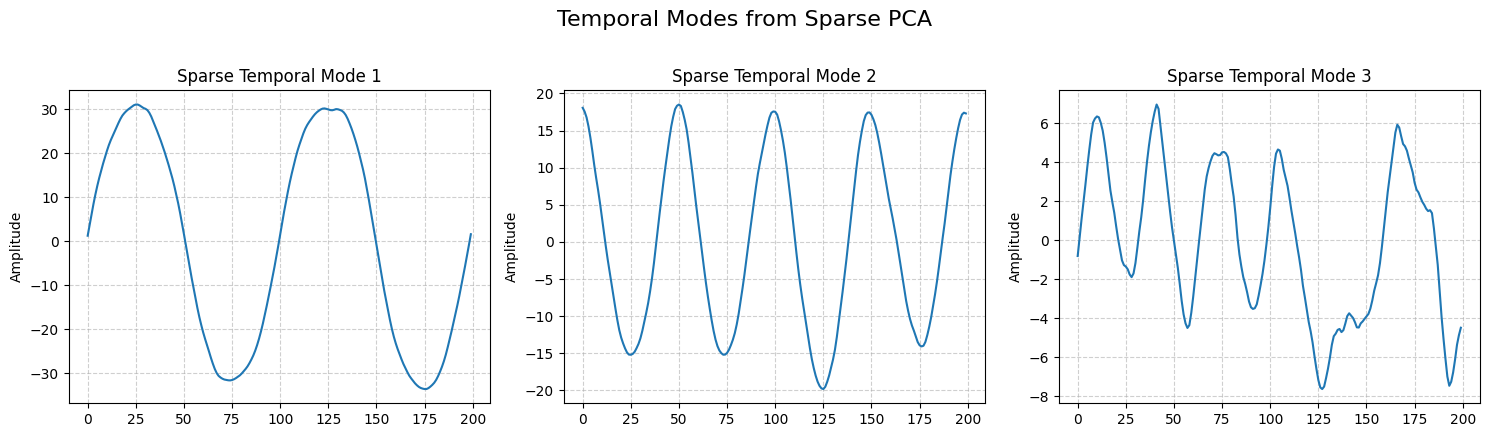

In [ ]:
#@title 4. Extract and Visualize the Sparse Modes -- no need to see the code
sparse_modes = spca.components_
print("Visualizing the sparse spatial modes...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
cmap = 'RdBu_r'

for i, ax in enumerate(axes.flat):
    if i < len(sparse_modes):
        mode_2d = sparse_modes[i].reshape(xx.shape)
        vmax2 = np.abs(mode_2d).max()
        vmin2 = -vmax2

        pcm = ax.pcolormesh(xx, yy, mode_2d, cmap=cmap, vmin=vmin2, vmax=vmax2, shading='gouraud')
        ax.set_title(f'Sparse Mode {i+1}')
        ax.set_aspect('equal', 'box')
        fig.colorbar(pcm, ax=ax)
    else:
        ax.set_visible(False)

plt.suptitle(f'Sparse PCA with alpha={alpha_regularization} (on Standardized Data)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 1. Transform the scaled data to get the temporal coefficients.
# The shape will be (n_snapshots, n_components)
X_transformed_sparse = spca.transform(X_scaled)

# 2. Plot the temporal evolution of each sparse mode
print("Visualizing the sparse temporal modes...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Ensure axes is always an array, even if n_sparse_modes is 1
if n_sparse_modes == 1:
    axes = [axes]

for i, ax in enumerate(axes.flat):
  if i < len(sparse_modes):
    ax.plot(X_transformed_sparse[:, i])
    ax.set_title(f'Sparse Temporal Mode {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True, linestyle='--', alpha=0.6)
  else:
    ax.set_visible(False)
    ax.set_xlabel('Time Step')

plt.suptitle('Temporal Modes from Sparse PCA', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [ ]:
print("Reconstructing data from sparse PCA modes...")

# 2. Reconstruct the data by multiplying the coefficients by the sparse modes.
# This gives the result in the centered, standardized space.
X_reconstructed_scaled = X_transformed_sparse @ spca.components_

# 3. Undo the standardization to bring the data back to its original variance.
# This is a crucial step.
X_reconstructed_centered = scaler.inverse_transform(X_reconstructed_scaled)

# 4. Add the mean back to reverse the initial centering.
X_reconstructed_final = X_reconstructed_centered + X_mean


print("Reconstruction complete.")

# Compute the explained variance using Frobenius norm
reconstruction_error = np.linalg.norm(X_speed - X_reconstructed_final, ord='fro') / np.linalg.norm(X_speed, ord='fro')
print(f"Explained variance: {100 - reconstruction_error * 100:.2f}%")

# ---
## Animate the Reconstructed Flow
# ---

print("Creating animation of the sparse PCA reconstructed flow...")

ani_sparse_reconstructed = animate_flow(
    X_reconstructed_final,
    xx,
    yy,
    f"Reconstructed Flow ({n_sparse_modes} Sparse Modes)",
    vmin,
    vmax
)

# Display the animation in the Colab notebook
display(HTML(ani_sparse_reconstructed.to_html5_video()))

Reconstructing data from sparse PCA modes...
Reconstruction complete.
Explained variance: 95.90%
Creating animation of the sparse PCA reconstructed flow...


## Classification / clustering
When no labels guide us, clustering becomes our lens for discovering latent groupings—“natural categories” that emerge purely from the geometry of the data cloud.  Formally we are looking for a partition of the point set $\{\mathbf{x}_i\}_{i=1}^N\subset\mathbb{R}^p$ that makes members of the same cluster more similar to one another than to points outside.  Yet similarity is in the eye of the algorithm.  **$k$-means** measures it with global Euclidean distance from movable centroids and therefore prefers compact, roughly spherical groups; **hierarchical linkage** builds a full dendrogram by agglomerating the closest pairs, exposing structure at every scale but forcing the analyst to decide where to “cut” the tree; **spectral clustering** turns the data into a nearest‑neighbour graph and seeks a low‑conductance cut, capturing connectivity rather than simple distance.  We will illustrate these biases with a deliberately eclectic 2‑D toy set that combines tight Gaussian blobs, an elongated cigar, a curved crescent and a sprinkling of stray points.  Watching each method succeed on some shapes and stumble on others makes vivid the central lesson: clustering is not a one‑size‑fits‑all tool but a family of algorithms whose output reflects the particular notion of proximity they encode.


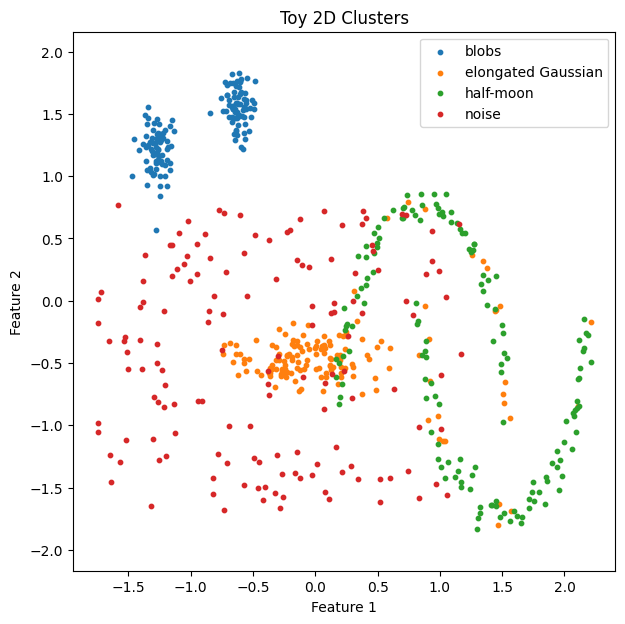

In [ ]:
#@title Data generation and k-means clustering code -- run this cell to generate the data, no need to look at the code

def k_means_step(X, centroids):
    """
    Inputs:
    X : (N_samples, N_features) matrix
        Data to cluster.
    centroids : (n_clusters, N_features) matrix
    """

    n_clusters = centroids.shape[0]

    # check connectivity of centroids
    labels = np.zeros(X.shape[0], dtype=int)
    d = np.zeros((n_clusters))
    for i in range(X.shape[0]):
        for k in range(n_clusters):
            d[k] = np.linalg.norm(X[i,:] - centroids[k,:])
        labels[i] = np.argmin(d)  # assign to the closest centroid


    new_centroids = np.zeros(centroids.shape)
    for k in range(centroids.shape[0]):
        new_centroids[k,:] = np.mean(X[labels == k, :], axis=0)
    return labels, new_centroids

def k_means(X, n_clusters=3, max_iter=100, n_inits=10):
    """
    K-means clustering algorithm.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    n_clusters : int
        Number of clusters.
    max_iter : int
        Maximum number of iterations.
    n_inits : int
        Number of times the algorithm will be run with different centroid seeds.

    Returns
    -------
    labels : (N_samples,) array-like
        Cluster labels for each sample.
    centroids : (n_clusters, N_features) array-like
        Final cluster centroids.
    """
    # Initialize random centroids
    loss = np.inf
    for k in range(n_inits):
        np.random.seed(k)
        initial_indices = np.random.choice(X.shape[0], n_clusters, replace=False)
        centroids = X[initial_indices, :]

        for _ in range(max_iter):
            labels, new_centroids = k_means_step(X, centroids)
            if np.all(centroids == new_centroids):
                break  # Convergence
            centroids = new_centroids

        loss_new = np.sum((X - centroids[labels])**2)
        if loss_new < loss:
            loss = loss_new
            best_labels = labels
            best_centroids = centroids

    return best_labels, best_centroids


def animated_kmeans_process(X, centroids, n_frames=4, interval=100):
    """
    Animated k-means clustering process.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    n_clusters : int
        Number of clusters.
    n_frames : int
        Number of frames in the animation.
    interval : int
        Delay between frames in milliseconds.
    """
    # # Initialize random centroids
    # np.random.seed(1)
    # initial_indices = np.random.choice(X.shape[0], n_clusters, replace=False)
    # centroids = X[initial_indices, :]

    # get the labels for initial centroids
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        d1 = np.linalg.norm(X[i,:] - centroids[0,:])
        d2 = np.linalg.norm(X[i,:] - centroids[1,:])
        d3 = np.linalg.norm(X[i,:] - centroids[2,:])
        if d1 < d2 and d1 < d3:
            labels[i] = 0
        elif d2 < d1 and d2 < d3:
            labels[i] = 1
        else:
            labels[i] = 2


    # Prepare the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    scat = ax.scatter(X[:, 0], X[:, 1], c='lightgray', s=10)
    scat.set_array(labels)  # Initial colors based on labels
    centroid_scat = ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')
    ax.set_title("K-means Clustering Process")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    # fig.show()

    def update(frame):
        nonlocal centroids
        nonlocal labels

        scat.set_array(labels)  # Update scatter plot colors based on labels
        centroid_scat.set_offsets(centroids)  # Update centroid positions

        labels, new_centroids = k_means_step(X, centroids)
        centroids = new_centroids
        return scat, centroid_scat

    ani = FuncAnimation(fig, update, frames=n_frames, interval=interval, blit=True)
    plt.close(fig)  # Prevent static output in Jupyter Notebook
    return HTML(ani.to_jshtml())


# import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler

# Function to generate toy 2D clusters
def toy_2D_clusters(rng=0):
    rng = np.random.RandomState(rng)

    # A: two tight blobs
    blob_A, _ = make_blobs(n_samples=150, centers=[(-7, 4), (-3, 5)],
                           cluster_std=0.4, random_state=rng)
    # B: elongated Gaussian
    cov = np.array([[4, 0.0], [0.0, 0.1]])
    blob_B = rng.multivariate_normal(mean=[0, 0], cov=cov, size=120)

    # C: half‑moon
    moon, _ = make_moons(n_samples=180, noise=0.05, random_state=rng)
    moon *= 4; moon += [6, -1]

    # D: stray noise
    noise = rng.uniform(low=[-10, -3], high=[8, 3], size=(150, 2))

    X = np.vstack([blob_A, blob_B, moon, noise])
    return StandardScaler().fit_transform(X)  # scale for fair distance use

# Generate data and visualize it
X_all = toy_2D_clusters(rng=1827)  # Generate toy clusters
datasets = ["blobs", "elongated Gaussian", "half-moon", "noise"]

plt.figure(figsize=(7, 7))
for k,set in enumerate(datasets):
    plt.scatter(X_all[k * 150:(k+1)*150-1, 0], X_all[k * 150:(k+1)*150-1, 1], s=10, label=set)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.legend()
plt.title("Toy 2D Clusters")
plt.show()

num_dict = {"blobs": 0,
            "elongated": 1,
            "moons": 2,
            "noise": 3}

### K-means
K-means is a very simple idea for classifying data. Suppose the data lives in $\mathbb{R}^d$, if we have $k$ points in $\mathbb{R}^d$, it is natural to classify each point of the wider data set based on which of the $k$ points it is closest to. This then results in $k$ clusters. K-means is the algorithm of iterating this grouping with moving the central points. Simply the algorithm can be described as

1. Generate $k$ random starting points, called $c_j^0$
2. Find the data points $\{X_i^{j,n}\}$ which has $c_j^{n}$ the closest
3. Update the central points to according to $c_j^{n+1} = $ mean($\{X_i^{j,n}\}$)
4. Go to 2, unless $c_j^{n+1} = c_j^n$.

Please watch the animated illustration on a dataset of your choosing. Here we use $k=3$

In [ ]:
# Illustration of k-means clustering
np.random.seed(1827)  # For reproducibility
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

k  = num_dict[dataset]
X = X_all[k * 150:(k+1)*150-1, :]
cent = np.hstack((np.random.uniform(np.min(X[:,0]), np.max(X[:,0]), size = (3, 1)), np.random.uniform(np.min(X[:,1]), np.max(X[:,1]), size = (3, 1))))
animated_kmeans_process(X, cent, n_frames=10, interval=500)

We call the central points which define the clusters, *centroids*, and the regions of $\mathbb{R}^d$ belonging to each centroid are called *voronoids*. The algorithm described is guaranteed to converge, but because the first step in the algorithm, it is not deterministic. For this reason we must run the algorithm multiple times with different initial centroids, and chose the best results. Usually we quantify the best as being the one minimising $\sum_{i,j} ||{c_j-X_i^j}||$ for the final centroids.

Try different numbers of clusters on all of the datasets

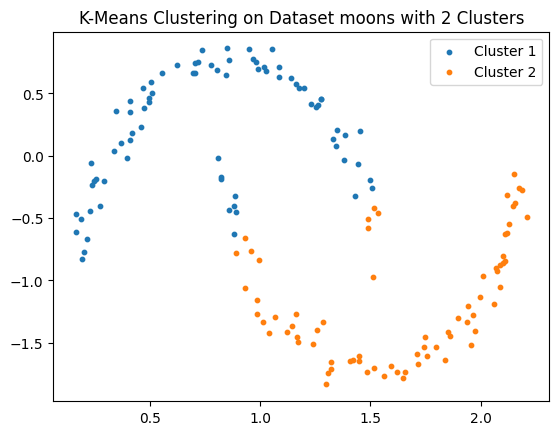

In [ ]:
# K-Means on all datasets
# Chose number of clusters
k = 2  # Change this to select a different number of clusters
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

kk = num_dict[dataset]
X = X_all[kk * 150:(kk+1)*150-1, :]
labels, centroids = k_means(X, n_clusters=k, max_iter=100, n_inits=10)

for i in range(k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, label=f'Cluster {i+1}')
plt.legend()
plt.title(f'K-Means Clustering on Dataset {dataset} with {k} Clusters')
plt.show()

An important limitation of k-means is that the centroids will always be convex. This we can see is not necessarily desirable by looking at the result of K-means on dataset 2. If you were to manually cluster this dataset, you would likely say that each of the crescents are their own clusters, but K-means can't give that as a result.

### Hierarchical clustering and Dendrograms
Hierarchical (agglomerative) clustering views a data set as a hierarchy of nested groups. Begin with every point in its own cluster; at each step merge the two clusters that are closest according to a *linkage* criterion. In this lab we will contrast two extremes:

* **Single linkage**

  $d_{\text{single}}(A,B)=\displaystyle\min_{i\in A,\;j\in B}\lVert\mathbf{x}_i-\mathbf{x}_j\rVert$
  Merging is driven by the *nearest* pair of points, so the algorithm is keen to join clusters connected by even a thin “chain” of samples. This tendency reveals elongated or curved structures (our crescent), but it can just as easily let stray points bridge otherwise distinct groups.

* **Ward linkage**

  $d_{\text{Ward}}(A,B)=\dfrac{|A|\,|B|}{|A|+|B|}\,\lVert\bar{\mathbf{x}}_A-\bar{\mathbf{x}}_B\rVert^{2}$
  Here the distance equals the increase in total within‑cluster variance were $A$ and $B$ merged. The rule therefore favours compact, roughly isotropic clusters—behaviour reminiscent of $k$-means—yet it produces an entire hierarchy instead of fixing $k$ in advance.

The sequence of merges is recorded in a **dendrogram**, a binary tree whose leaves are individual samples and whose branch heights mark the linkage distances at which clusters fused. Cutting the dendrogram with a horizontal line at height $h$ yields the partition first produced when inter‑cluster distance exceeded $h$; sliding this cut interactively exposes structure from fine to coarse scales. Single linkage will keep the crescent intact at low cuts but may chain noise into it; Ward will absorb noise into variance‑minimising groups yet cleanly separates the tight Gaussian blobs. Other linkage choices—complete, average, centroid—sit between these two, balancing sensitivity to chaining against a bias for compactness, but today’s exercise with single and Ward already reveals how the linkage metric encodes geometric assumptions that fundamentally shape the resulting clusters.



In [ ]:
#@title Functions for hierarchical clustering and dendrogram plotting -- no need to look at the code, just run the cell
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
def heirarchical_clustering(X, method='ward', n_clusters=None):
    """
    Perform hierarchical clustering on the data X using the specified method.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    method : str
        The linkage method to use. Options are 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'.

    Returns
    -------
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    """
    # Compute the distance matrix
    dist_matrix = pdist(X)
    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method=method)
    return Z

def plot_dendrogram(Z, labels=None, title='Hierarchical Clustering Dendrogram'):
    """
    Plot a dendrogram for the hierarchical clustering.

    Parameters
    ----------
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    labels : list of str, optional
        Labels for the leaves of the dendrogram.
    title : str, optional
        Title of the dendrogram plot.
    """
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=labels, leaf_rotation=90)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

def plot_clusters(X, Z, n_clusters, title='Clusters'):
    """
    Plot the clusters formed by hierarchical clustering.

    Parameters
    ----------
    X : (N_samples, N_features) array-like
        Data to cluster.
    Z : (N_samples-1, 4) ndarray
        The hierarchical clustering encoded as a linkage matrix.
    n_clusters : int
        The number of clusters to form.
    title : str, optional
        Title of the plot.
    """
    from scipy.cluster.hierarchy import fcluster

    labels = fcluster(Z, n_clusters, criterion='maxclust')

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.axis('equal')
    plt.show()

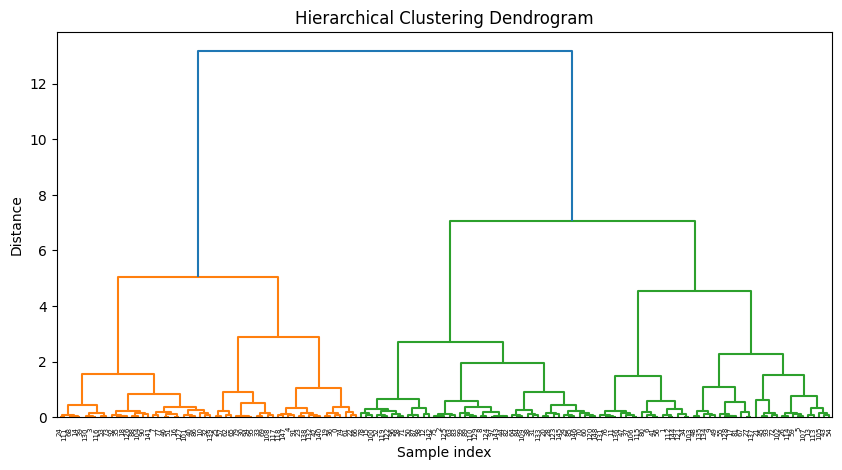

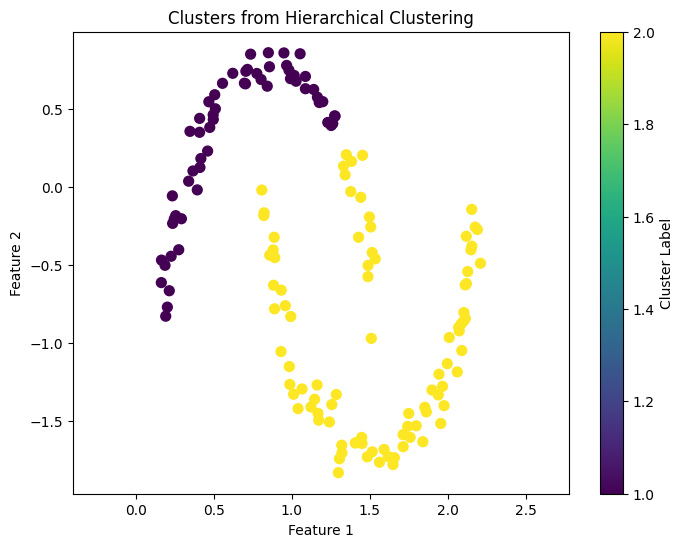

In [ ]:
# Example usage of hierarchical clustering and dendrogram plotting
# Choose the dataset and number of clusters
n_clusters = 2  # Change this to select a different number of clusters
dataset = "moons" # Choose dataset, "blobs", "elongated", "moons", or "noise"

kk = num_dict[dataset]
X = X_all[kk * 150:(kk+1)*150-1, :]

# You might adjust the method. Ward doesn't work well for all datasets.
Z = heirarchical_clustering(X, method='ward') # Try both 'ward' and 'single' methods to see the difference
plot_dendrogram(Z, title='Hierarchical Clustering Dendrogram')
plot_clusters(X, Z, n_clusters=n_clusters, title='Clusters from Hierarchical Clustering')


## Anomaly detection
In anomaly detection we flip the usual learning question: instead of modelling *all* the variability in a data set, we first build a notion of what “normal” looks like and then flag samples that fall outside that description. Because true anomalies are typically rare and unlabeled, the task is almost always **unsupervised**. The output is not a class but a **score**—higher means “more unusual”—followed by a threshold that decides whether to raise an alarm. Setting that threshold is part of the problem: too low and the system cries wolf, too high and genuine faults slip through. Practical recipes fix it by an assumed contamination rate (e.g. the highest 2 % of scores) or by cross‑checking against domain limits.

Different algorithms operationalise “unusual” in different ways. Local methods, such as the $k$-nearest‑neighbour distance score, compare each point only to its immediate neighbourhood and are quick to spot sparse outliers in dense clouds. Global boundary methods like the One‑Class SVM enclose the bulk of the data in a flexible surface and mark anything outside as suspect; they cope better when “normal” fills an irregular but connected region. The following sections apply both viewpoints to a synthetic pulsatile‑pressure trace, showing how the choice of score and threshold trades false positives against missed detections.

We begin by generating the data. The raw data will be a time-series of pressure measurements, with faults such as dropouts and spikes injected into the data set and some Gaussian noise. For the classification, the signal will be divided into windows and the four statistical measures will be used to analyse the windows (mean, standard deviation, skewness, kurtosis).

In [ ]:
#@title No need to look at the code below, just run it to intitialize the synthetic pressure signal generator
def pressure_signal(n_pts=4000,
                    fs=200,                       # Hz
                    noise_std=0.05,
                    spike_frac=0.003,
                    dropout_count=4,
                    shift_count=0,
                    rng=None):
    """
    Generate a synthetic pulsatile pressure trace with injected anomalies.

    Returns
    -------
    t      : (n_pts,)   time axis [s]
    p      : (n_pts,)   pressure signal
    is_anom: (n_pts,)   boolean mask, True where an anomaly was injected
    anomaly_type: (n_pts,)   string array, type of anomaly injected at each point
    """
    rng = np.random.default_rng(rng+1)
    t = np.arange(n_pts) / fs

    # --- clean baseline: two harmonics ---------------------------------------
    p = 2*np.sin(2*np.pi*2*t) + 0.5*np.sin(2*np.pi*4*t)
    anomaly_type = np.full(n_pts, "baseline", dtype=object)

    # --- additive Gaussian noise --------------------------------------------
    p *= 1 + noise_std * rng.standard_normal(n_pts)

    is_anom = np.zeros(n_pts, dtype=bool)

    # --- spikes --------------------------------------------------------------
    n_spike = int(spike_frac * n_pts)
    spike_idx = rng.choice(n_pts, n_spike, replace=False)
    p[spike_idx] += rng.uniform(3, 4, size=n_spike) * rng.choice([-1, 1], n_spike)
    is_anom[spike_idx] = True
    anomaly_type[spike_idx] = "spike"


    # --- drop‑outs -----------------------------------------------------------
    for _ in range(dropout_count):
        start = rng.integers(0, n_pts-50)
        length = rng.integers(20, 40)
        p[start:start+length] = 0.0
        is_anom[start:start+length] = True
        anomaly_type[start:start+length] = "dropout"

    # --- slow level shifts ---------------------------------------------------
    for _ in range(shift_count):
        start = rng.integers(0, n_pts-200)
        amp   = rng.uniform(-1.5, 1.5)
        decay = rng.uniform(0.02, 0.05)        # 1/decay ≈ time‑constant [s]
        span  = np.arange(n_pts-start)
        shift = amp * np.exp(-decay * span)
        p[start:] += shift[: n_pts-start]
        is_anom[start:start+150] = True        # mark first 150 pts as anomalous
        anomaly_type[start:start+150] = "shift"

    return t, p, is_anom, anomaly_type


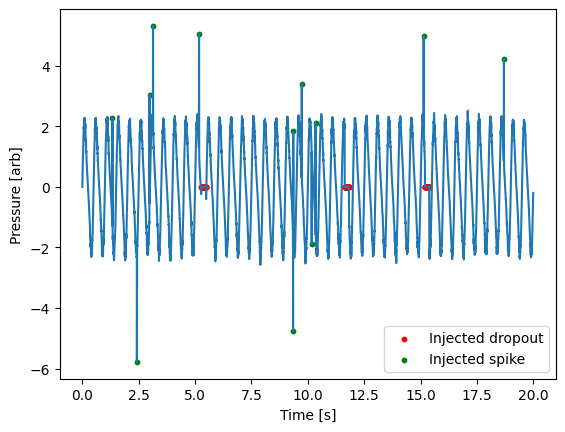

In [ ]:
#@title Run this to generate and visualize the synthetic pressure signal -- no need to look at the code
t, p, is_anom_true,anomaly_type = pressure_signal(fs=200, rng=2020)
plt.plot(t, p)

colrs = ["r", "g", "m", "y"]
k = 0
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}', c=colrs[k])
    k += 1

plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.show()


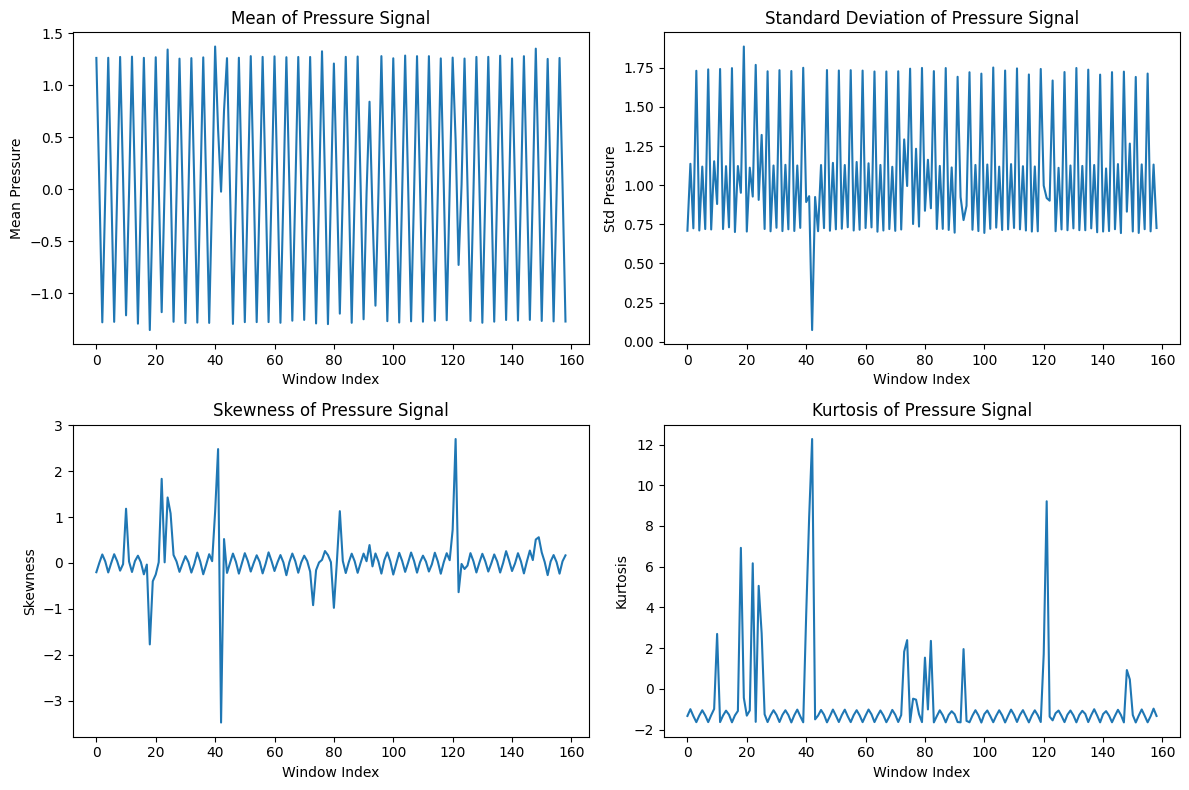

In [ ]:
#@title Run this to get the window features -- no need to look at the code
from scipy.stats import skew, kurtosis

def window_features(p, fs, win_len=0.25, stride=0.125):
    """
    Parameters
    ----------
    p       : 1‑D array
    fs      : sampling frequency
    win_len : seconds, window length
    stride  : seconds, hop length

    Returns
    -------
    X       : (n_win, 4)  feature matrix  [mean, std, skew, kurtosis]
    idx_win : (n_win,)    index of window start in the original signal
    """
    L = int(win_len * fs)
    H = int(stride * fs)
    idx_win = np.arange(0, len(p)-L+1, H)
    feats = []
    for i in idx_win:
        seg = p[i:i+L]
        feats.append([seg.mean(), seg.std(), skew(seg), kurtosis(seg)])
    return np.array(feats), idx_win, stride


X, idx, H = window_features(p, fs=200)

# Plot the features extracted from the windows
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(X[:, 0], label='Mean')
plt.title('Mean of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Mean Pressure')
plt.subplot(2, 2, 2)
plt.plot(X[:, 1], label='Standard Deviation')
plt.title('Standard Deviation of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Std Pressure')
plt.subplot(2, 2, 3)
plt.plot(X[:, 2], label='Skewness')
plt.title('Skewness of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Skewness')
plt.subplot(2, 2, 4)
plt.plot(X[:, 3], label='Kurtosis')
plt.title('Kurtosis of Pressure Signal')
plt.xlabel('Window Index'); plt.ylabel('Kurtosis')
plt.tight_layout()


### $k$-NN for anomaly detection
The $k$-nearest‑neighbour (kNN) anomaly score treats each sample as a probe of **local density**: if you have to travel far to reach your $k$th neighbour, you must be in a sparse part of the space and are therefore a candidate outlier.  Formally, for a point $\mathbf{x}$ let

$$
s_{k}(\mathbf{x})=\frac1k\sum_{j=1}^{k} \lVert\mathbf{x}-\mathbf{x}_{(j)}\rVert ,
$$

where $\mathbf{x}_{(j)}$ is the $j$th nearest neighbour of $\mathbf{x}$ in the training set.  Large $s_{k}$ means low local density; ranking all samples by this score and thresholding the largest few per cent yields the anomaly set.

This use of $k$-NN differs from the *symmetric graphs* we built for spectral clustering.  There, the edge $i\!\rightarrow\!j$ existed **for both directions**; the goal was a balanced, undirected graph for Laplacian cuts.  In anomaly detection the neighbourhood is evaluated **per point only once** and never symmetrised, because we care about *how isolated that point is*, not about maintaining reciprocity.  As a result, a lone outlier may have large distances to its neighbours even though those neighbours (dense, normal points) have small distances between themselves—exactly the asymmetry we need to flag the outlier.  The only hyper‑parameter is $k$; small values make the score sensitive to fine local structure, while larger $k$ smooth over noise at the risk of diluting rare but genuine anomalies.

Once the scores are generated, we need to determine where to put the cut-off. There are many ways of doing this, you could put a hard cap and say that if $s_{k}(x)$ is greater than a specific value it is an anomaly, but this requires good knowledge about the data set in order to choose the threshold, another option is to assume that there are $p$% faults and discard the $p$% of points with the highest scores. The method we will implement here though is to use K-means in order to construct the threshold. Experiment by choosing the value of $k$ and the number of clusters of K-means.

In [ ]:
#@title run this to initialize the k-NN anomaly detection code -- no need to look at the code
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def detect_knn_anomalies(X, k=5, contamination=0.05, metric='euclidean'):
    """
    k‑NN anomaly detection (distance‑based).

    Parameters
    ----------
    X            : (N_samples, N_features) array
    k            : int, number of neighbours
    contamination: float, fraction of samples to flag as anomalies
    metric       : str, distance metric for scikit‑learn

    Returns
    -------
    is_anom      : (N_samples,) bool array, True where sample is anomalous
    scores       : (N_samples,) float array, k‑NN distance score
    cutoff       : float, threshold applied to scores
    """

    # # standardize the data
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    nbrs = NearestNeighbors(n_neighbors=k + 1, metric=metric).fit(X)
    # distances[:, 0] is distance to itself (0) → skip
    distances, _ = nbrs.kneighbors(X, n_neighbors=k + 1, return_distance=True)
    scores = distances[:, 1:].mean(axis=1)     # average distance to k nearest neighbours

    # threshold by percentile
    cutoff = np.percentile(scores, 100 * (1 - contamination))
    is_anom = scores > cutoff
    return is_anom, scores, cutoff


In [ ]:
# Chose k, contamination ratio, and K-means clusters
k = 5  # number of neighbours for k-NN
contamination = 0.1  # fraction of samples to flag as anomalies when using thresholding
k_means_clusters = 3  # number of clusters for K-means
is_anom, scores, cutoff = detect_knn_anomalies(X, k=k, contamination=contamination)

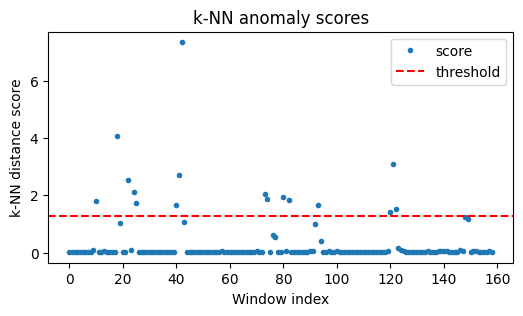

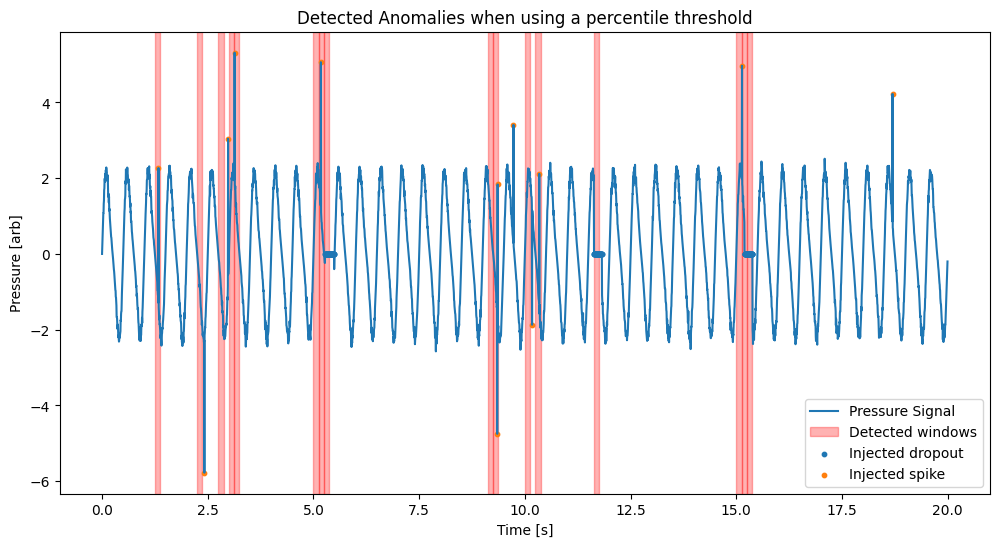

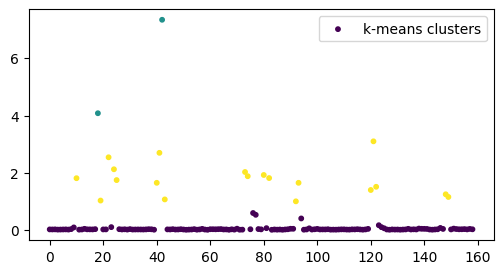

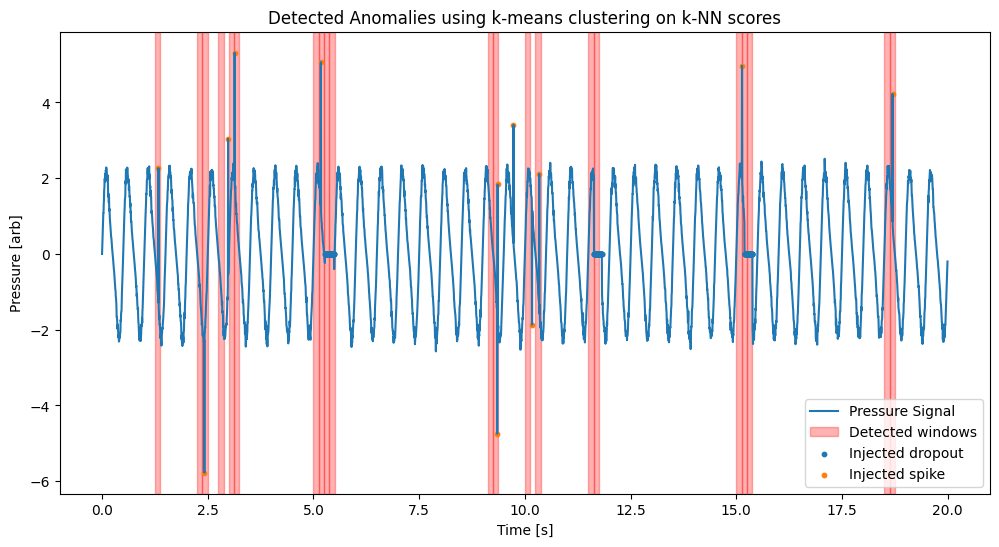

K-means anomalies flagged: 21 of 159 windows


In [ ]:
#@title Visualize the k-NN anomaly detection results -- no need to look at the code
plt.figure(figsize=(6, 3))
plt.plot(scores, '.', label='score')
plt.axhline(cutoff, color='r', linestyle='--', label='threshold')
plt.xlabel('Window index'); plt.ylabel('k‑NN distance score')
plt.title('k‑NN anomaly scores')
plt.legend()

# Plot the anomalies on the original pressure signal
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Detected windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Detected windows' if not legended else "")
        legended = True
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()

# overlay the true anomalies
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.title('Detected Anomalies when using a percentile threshold')
plt.show()

# Do k-means clustering on the scores

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k_means_clusters, random_state=42)
kmeans.fit(np.reshape(scores,(len(scores), 1)))

# plot the scores and the clusters
plt.figure(figsize=(6, 3))
plt.scatter(np.arange(len(scores)), scores, c=kmeans.labels_, cmap='viridis', s=10, label='k-means clusters')
plt.legend()
plt.show()

# plot the time series and indicate the anomalies
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
biggest_cluster = np.argmax(np.bincount(kmeans.labels_))  # find the largest cluster
is_anom = kmeans.labels_ != biggest_cluster
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Detected windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Detected windows' if not legended else "")
        legended = True

# overlay the true anomalies
for kind in np.unique(anomaly_type):
    if kind == "baseline":
        continue
    plt.scatter(t[anomaly_type == kind], p[anomaly_type == kind], s=10, label=f'Injected {kind}')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.title('Detected Anomalies using k-means clustering on k-NN scores')
plt.show()

print(f"K-means anomalies flagged: {is_anom.sum()} of {len(X)} windows")




## EXTRA MATERIALS BELOW HERE (ONE-CLASS SVM, GRAPH BASED CLUSTERING)

### One-Class Support Vector Machines
The **One‑Class SVM** builds a *global* envelope around the training data by learning a decision function that is positive on “normal” samples and negative elsewhere. In scikit‑learn this is implemented as the ν‑formulation of the support‑vector machine: given only the uncontaminated portion of the data, the algorithm maps each point into a high‑dimensional feature space (by default with an RBF kernel) and then finds the hyper‑plane that maximises its distance from the origin while allowing at most a fraction ν of the training points to fall on the wrong side. Geometrically, this hyper‑plane translates back into input space as a smooth, flexible boundary containing roughly $(1\!-\!ν)\times100\%$ of the data. The signed distance to that boundary is returned by `decision_function`; scikit‑learn’s `predict` simply labels negative distances as anomalies.

Three hyper‑parameters control the fit:

* **`nu`** (0 < ν ≤ 1) – upper bound on the expected proportion of outliers *and* a lower bound on the fraction of support vectors; start around 0.05 if you believe ≤ 5 % of points are anomalous.
* **`kernel`** – RBF (default) captures non‑linear shapes; linear and polynomial are available for strictly convex data.
* **`gamma`** – inverse squared length‑scale of the RBF; `'scale'` (default) sets it to $1/(p · \text{var}(X))$, but tuning tighter (larger gamma) shrinks the envelope, flagging more points.

Because the model optimises a global objective, it is less sensitive than kNN to local sampling density and can enclose an irregular yet connected “normal” region without fragmenting it. Pre‑processing the data with a `StandardScaler` is essential: the kernel uses Euclidean distance, so unscaled features distort the boundary. Once fitted, the One‑Class SVM scores new observations in $O(N_{\text{SV}} p)$ time, where $N_{\text{SV}}$ is the number of support vectors, making it fast enough for real‑time monitoring after the initial training pass.

For our lab, it will have to suffice to experiment a little with $\nu$

In [ ]:
# Choose the value of nu for the one-class SVM
nu = 0.1 # Try 0.01, 0.05, 0.1, 0.15, 0.3 or any other value between 0 and 1

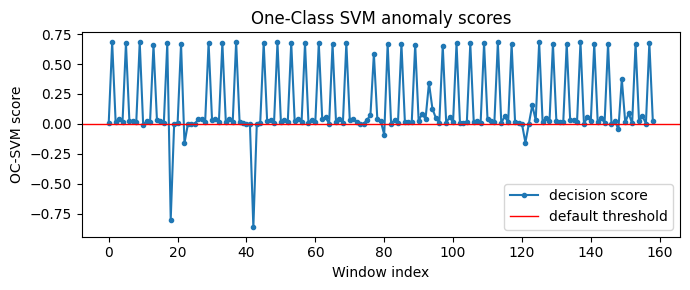

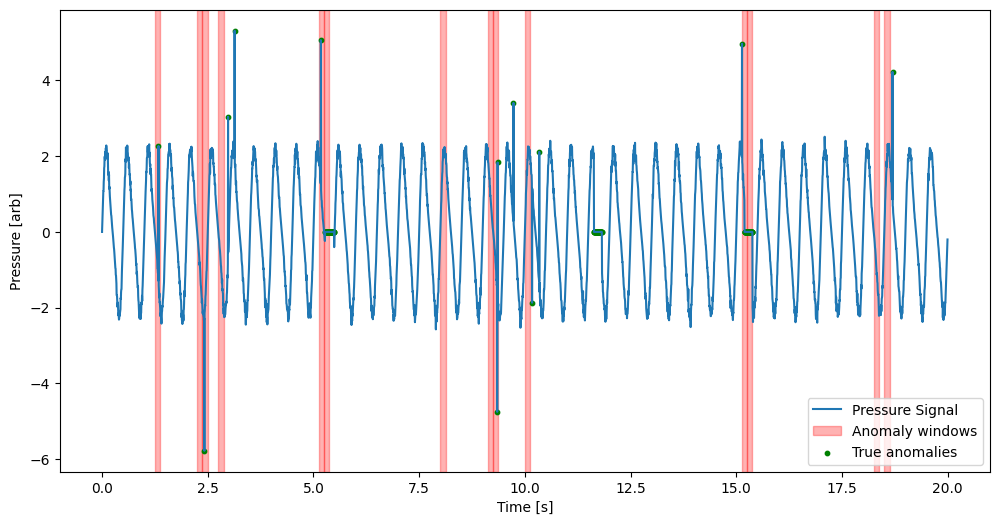

In [ ]:
#@title Run this to perform One-Class SVM anomaly detection -- no need to look at the code
# --- One‑Class SVM anomaly detection -----------------------------------------
from sklearn.svm import OneClassSVM

# 0.  Choose a training mask  (middle 80 % of windows)
n_win = len(idx)
train_mask = (idx >= idx[int(0.10 * n_win)]) & (idx < idx[int(0.90 * n_win)])

# 1.  Standardise features (mean‑0, var‑1)   ------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2.  Fit One‑Class SVM on "normal" windows   -----------------------------
ocsvm = OneClassSVM(kernel='rbf',
                    nu=nu,         # expected fraction of anomalies
                    gamma='scale')   # 1 / (n_features * var)
ocsvm.fit(X_std[train_mask])

# 3.  Decision scores (positive ⇒ inlier, negative ⇒ outlier) ------------
scores = ocsvm.decision_function(X_std)      # shape (n_win,)

# 4.  Flag anomalies by sign  (or set your own threshold) ----------------
is_anom = scores < 0

# 5.  Plot score curve and threshold -------------------------------------
plt.figure(figsize=(7, 3))
plt.plot(scores, '.-', label='decision score')
plt.axhline(0, color='r', linewidth=1, label='default threshold')
plt.xlabel('Window index'); plt.ylabel('OC‑SVM score')
plt.title('One‑Class SVM anomaly scores')
plt.legend(); plt.tight_layout()

# 6.  Visualise anomalies on the original signal --------------------------
plt.figure(figsize=(12, 6))
plt.plot(t, p, label='Pressure Signal')
legended = False
for i in range(len(is_anom)):
    if is_anom[i]:
        try:
            plt.axvspan(t[idx[i]], t[idx[i]]+H, color='red', alpha=0.3, label='Anomaly windows' if not legended else "")
        except IndexError:
            plt.axvspan(t[idx[i]], t[-1], color='red', alpha=0.3, label='Anomaly windows' if not legended else "")
        legended = True

# overlay the true anomalies
plt.scatter(t[is_anom_true], p[is_anom_true], c='g', s=10, label='True anomalies')
plt.xlabel('Time [s]'); plt.ylabel('Pressure [arb]')
plt.legend()
plt.show()


### Graph based clustering
Graph‑based clustering begins by **turning the data set into a network**. Each observation is a node; an edge appears between two nodes if they are judged “similar,” and the edge weight encodes *how* similar. Building this *similarity graph* is the key modelling step. Some of the most common choices are:

* **ε‑neighbourhood graph:** connect points whose Euclidean distance is below a user‑chosen ε.
* **$k$-nearest‑neighbour graph:** draw a directed (or symmetrised) edge from each point to its $k$ closest neighbours.
* **Kernel graph:** keep *all* pairs but weight them with a decaying function such as $w_{ij}=\exp(-\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^{2}/2\sigma^{2})$.

These constructions replace geometric coordinates by **connectivity**, making curved or elongated clusters easy to capture: if points lie on the same manifold they remain linked through short paths even when straight‑line distance is misleading.

In many practical problems the notion of similarity itself is multi‑faceted—think of pressure sensors that are close in space *and* highly correlated in time. A graph can express this by *combining* cues in the weight formula, for example

$$
w_{ij}= \exp\!\bigl(-\tfrac{\lVert\mathbf{x}_i-\mathbf{x}_j\rVert^{2}}{2\sigma_x^{2}}\bigr)\,
        \exp\!\bigl(-\tfrac{|t_i-t_j|^{2}}{2\sigma_t^{2}}\bigr),
$$

or by adding separate edge sets and summing their weights. The important point is that **once the graph is built, the downstream clustering step is algorithm‑agnostic**: spectral partitioning, modularity maximisation, or label‑propagation can all act on the same adjacency matrix. Our notebooks will therefore separate the workflow into two stages—(i) graph construction and inspection, (ii) graph cutting—so that you can see how different similarity choices influence the communities that emerge when we apply Ward‑like or spectral cuts later on.


#### $\varepsilon$-Neighbourhood
This is a very simple kind of graph. Here, the pointwise distance between every point is computed. If $||x_i-x_j||$ is smaller than $\varepsilon$ for a user specified value, then the two nodes are connected. In the unweighted case this means that we set $w_{ij}=w_{ji} = 1$, while in the weighted case we say that $w_{ij} = f(||x_i-x_j||)$ for some non-negative decaying function $f$. For all unconnected nodes $x_i,x_j$, the weight value is $w_{ij}=0$.

Experiment with different values for the neighbourhood size $\varepsilon$ on the same datasets, since these graphs are not fully connected this can sometimes result in sufficiently good clustering without ever actually cutting the graph.

In [ ]:
#@title Functions for creating and plotting graphs from the data -- no need to look at the code, just run the cell to define the functions

def compute_distance_matrix(X):
    """
    Compute the pairwise distance matrix for the dataset X.
    X is expected to be a 2D array where each row is a data point.
    """
    D = np.zeros((X.shape[0], X.shape[0]), dtype=float)
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            D[i, j] = np.linalg.norm(X[i] - X[j])
            D[j, i] = D[i, j]  # exploit symmetry
    return D


def eps_neighbourhood_graph(X, epsilon, weighted=False):
    """
    Create an epsilon-neighbourhood graph from the dataset X.
    X is expected to be a 2D array where each row is a data point.
    Returns an adjacency matrix where entry (i, j) is True if points i and j are within epsilon distance.
    """
    D = compute_distance_matrix(X)
    adjacency_matrix = D < epsilon
    np.fill_diagonal(adjacency_matrix, False)  # no self-loops

    if weighted:
        # The metric is exp(-D/epsilon) to give higher weights to closer points
        adjacency_matrix = adjacency_matrix.astype(float) * np.exp(-(D / epsilon)**2)
    return adjacency_matrix

def knn_neighbourhood_graph(X, k, mode="and", weighted=False):
    """
    Create a k-nearest neighbour graph from the dataset X.
    X is expected to be a 2D array where each row is a data point.
    Returns an adjacency matrix where entry (i, j) is True if points i and j are among the k nearest neighbours.
    """
    if mode not in ["and", "or"]:
        raise ValueError("Mode must be 'and' or 'or'.")

    D = compute_distance_matrix(X)
    adjacency_matrix = np.zeros(D.shape, dtype=bool)

    for i in range(D.shape[0]):
        # Get indices of the k smallest distances (excluding self)
        knn_indices = np.argsort(D[i])[:k + 1]
        adjacency_matrix[i, knn_indices] = True

    if mode == "and":
        adjacency_matrix = adjacency_matrix & adjacency_matrix.T  # make it symmetric
    elif mode == "or":
        adjacency_matrix = adjacency_matrix | adjacency_matrix.T

    if weighted:
        # The metric is exp(-D/max(D)) to give higher weights to closer points
        adjacency_matrix = adjacency_matrix.astype(float) * np.exp(-(D / np.max(D*adjacency_matrix))**2)

    np.fill_diagonal(adjacency_matrix, False)  # no self-loops
    return adjacency_matrix



def plot_graph_from_adjacency_matrix(adjacency_matrix, X, title="Graph"):
    """
    Plot a graph from an adjacency matrix and data points.
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.from_numpy_array(adjacency_matrix)
    pos = {i: (X[i, 0], X[i, 1]) for i in range(X.shape[0])}

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=10)
    plt.title(title)
    plt.show()


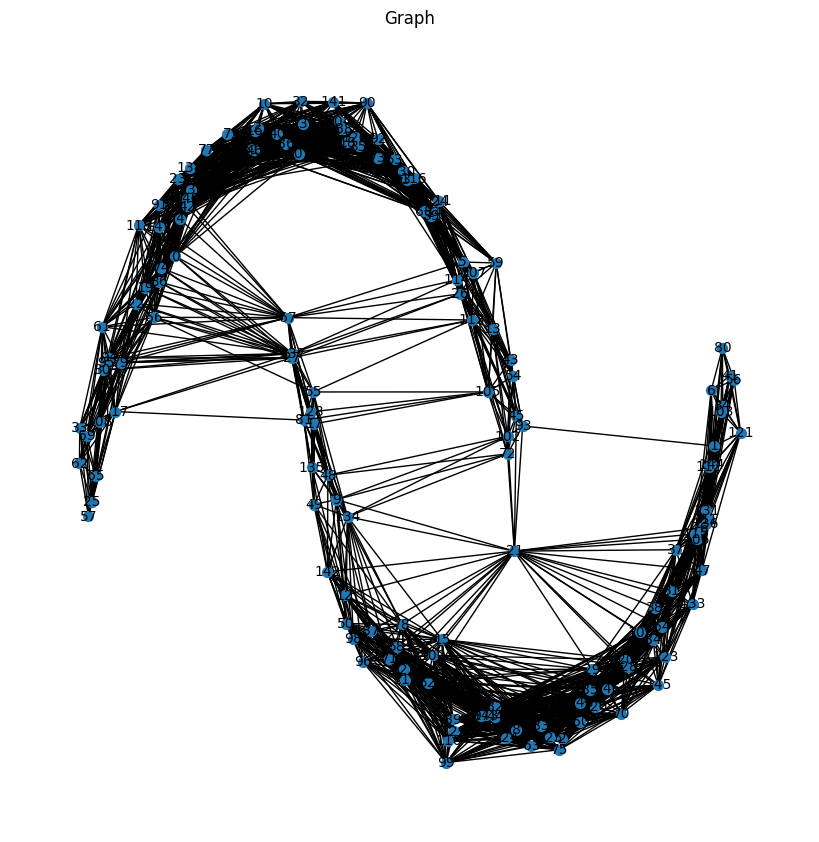

In [ ]:
# Choose data set
dataset = 2  # Change this to select a different dataset 0-3
X = X_all[dataset * 150:(dataset+1)*150-1, :]

epsilon = 0.6  # Set epsilon for the epsilon-neighbourhood graph, try a range of values from 0.1 to 1.0, see if you can find a good value for the dataset
adjacency_matrix = eps_neighbourhood_graph(X, epsilon)
plot_graph_from_adjacency_matrix(adjacency_matrix, X)

#### $k$-Nearest Neighbours for building graphs
Often, $k$-NN is thought of as a supervised classification algorithm, but that is not the only way to use it. Here we will be using it in an unsupervised manner to build graphs. As we are only going to be working with symmetric graphs, i.e. if $x_i$ is connected to $x_j$, then $x_j$ is connected to $x_i$, there are two versions of the algorithm. We name these two version *and*-mode, and *or*-mode, the names are given based on how ambiguous situations are resolved. The algorithm goes like this, for a given value of $k$.
1. For each $x_i$ in the data set, determine which \{x_{i_j}\}_{j=1}^k, are the $k$ closest other points in the data set.
2. In and-mode, connect $x_i$ to $x_j$ only if $x_j$ is one of $x_i$'s $k$ closest neighbours AND $x_i$ is one of $x_j$'s $k$ closest neighbours. In or-mode, connect $x_i$ to $x_j$ if $x_j$ is one of $x_i$'s $k$ closest neighbours OR $x_i$ is one of $x_j$'s $k$ closest neighbours.
3. Determine the weights $w_{ij}$, similarly to how it was described in the previous section

Try both modes and different values of $k$ on the previous datasets.

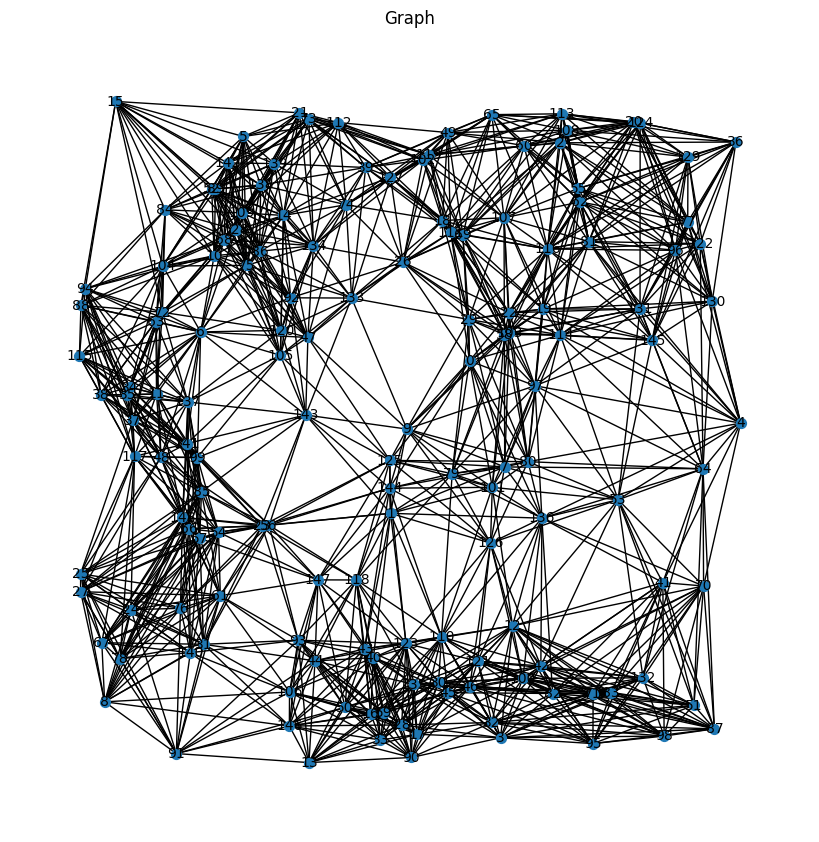

In [ ]:
dataset = 3  # Change this to select a different dataset 0-3
X = X_all[dataset * 150:(dataset+1)*150-1, :]
k = 16  # Set k for the k-nearest neighbour graph
mode = "or"  # Choose mode: "and" or "or"
adjacency_matrix_knn = knn_neighbourhood_graph(X, k, mode)
plot_graph_from_adjacency_matrix(adjacency_matrix_knn, X)

#### Cutting graphs and spectral clustering
Once the data have been converted into a weighted (or unweighted) graph, clustering can be phrased as cutting that graph into two or more pieces: remove a set of edges so that the remaining connected components become the clusters. A naïve strategy would be to sort all edges by weight and simply delete the weakest ones until the graph falls apart. This works on toy data but quickly shows its limitations: a single noisy point may detach prematurely, elongated clusters may shatter into chains, and large clusters are penalised because they contain more edges in absolute terms. In other words, how we measure the cost of a cut—and whether we balance that cost by cluster size—matters as much as which edges we remove. In order to continue the discussion we introduce two new matrices, the degree matrix $D$, which is diagonal and defined by $d_{ii} = \sum_j w_{ij}$, and the Laplacian of the graph $L=D-W$. We must also introduce notions of size on a graph, we usually use two measures of the graph $G$, $|G|$ is the number of vertices (nodes) in the graph, and vol$(G)$ is the diagonal sum of the degree matrix belonging to $G$.

A more principled view measures the cost of a cut as the total weight of edges that run between clusters and then balances that cost by the size of the clusters produced. Two widely used objectives embody this idea. *Ratio Cut* divides the inter‑cluster edge weight by the number of vertices on either side, discouraging tiny fragments; *Normalised Cut* divides instead by the total edge weight incident to each side, giving greater protection when degrees vary widely. More formally, we need to introduce a way to measure the connectedness of subgraphs. If $A$ and $B$ are subgraphs, their connectedness is defined as $W(A,B) = \sum_{i\in A, j\in B} w_{ij}$. The values of Ratio Cut and Normalised cut then read
* RatioCut$(A_1,\dots A_k) = \frac{1}{2}\sum_{i=1}^k \frac{W(A_i,A_i^c)}{|A_i|}$, where $A^c$ is the complement of $A$, and
* NCut $(A_1,\dots A_k) = \frac{1}{2}\sum_{i=1}^k \frac{W(A_i,A_i^c)}{\text{vol}(A_i)}$.

Both of these quantities become large if any subgraph becomes very small. Finding the true minimiser of these two quantities is a very difficult discrete optimisation problem. Thankfully the Rayleigh-Ritz theorem, and a relaxation of the discrete nature, makes both problems into eigenvalue problems of the Laplacian $L$ and the normalised Laplacian $\tilde{L} = D^{-1/2}LD^{-1/2}$.

The methods for both are identical except for which Laplacian is used. The algorithm is (for RatioCut) as follows for $k$ clusters

1. Compute the Laplacian
2. Compute the $k$ first eigenvectors $\mathcal{U} = [u_1,\dots, u_k]$ of $L$
3. To recover the discrete structure, treat each row of $\mathcal{U}$ as $k$ dimensional data and cluster these using some other algorithm such as K-means or hierarchical clustering


Experiment on our previous datasets

In [ ]:
#@title Code for spectral clustering -- run but no need to look at the code
def spectral_clustering(adjacency_matrix, n_clusters, type = "RatioCut", cluster_method="kmeans"):
    """
    Perform spectral clustering on the given adjacency matrix.
    Returns the cluster labels for each data point.
    """
    W = adjacency_matrix
    D = np.diag(np.sum(W, axis=1))  # degree matrix
    L = D - W  # Laplacian matrix

    if type == "RatioCut":
        # Compute the eigenvalues and eigenvectors of the Laplacian
        _, eigvecs = np.linalg.eigh(L)
        # Use the first n_clusters eigenvectors
        X = eigvecs[:, :n_clusters]
    elif type == "NormalizedCut":
        # Compute the normalized Laplacian
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L_norm = D_inv_sqrt @ L @ D_inv_sqrt
        _, eigvecs = np.linalg.eigh(L_norm)
        # Use the first n_clusters eigenvectors
        X = eigvecs[:, :n_clusters]
    else:
        raise ValueError("Unknown type. Use 'RatioCut' or 'NormalizedCut'.")
    if cluster_method == "kmeans":
        from sklearn.cluster import KMeans
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
        labels = clustering.fit_predict(X)
    elif cluster_method == "dendrogram":
        from scipy.cluster.hierarchy import fcluster, linkage
        Z = linkage(X, method='ward')
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    else:
        raise ValueError("Unknown cluster_method. Use 'kmeans' or 'dendrogram'.")
    return labels

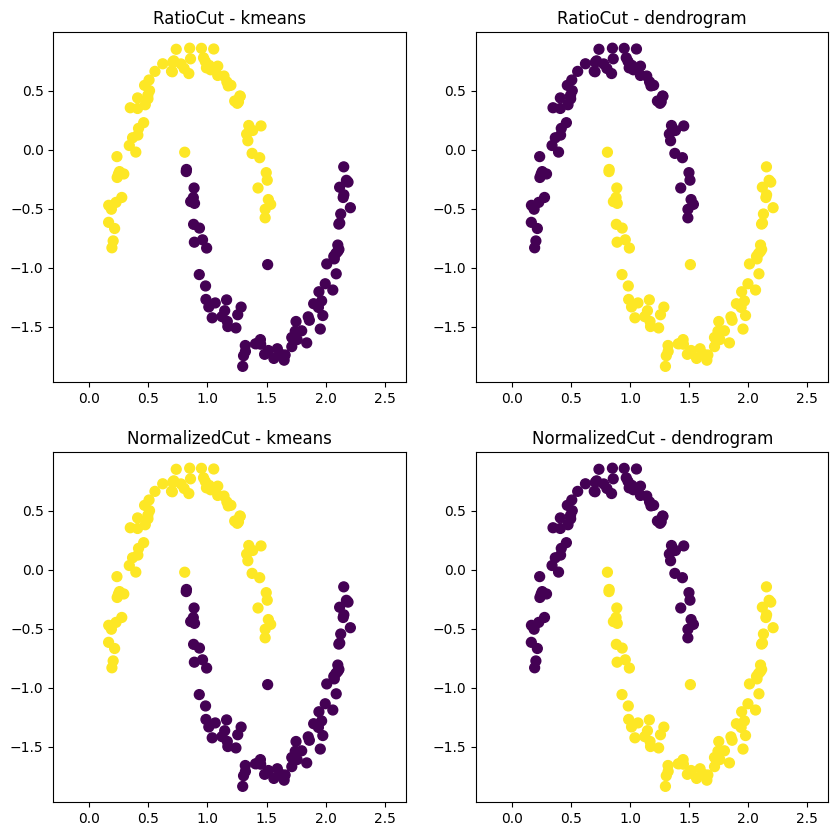

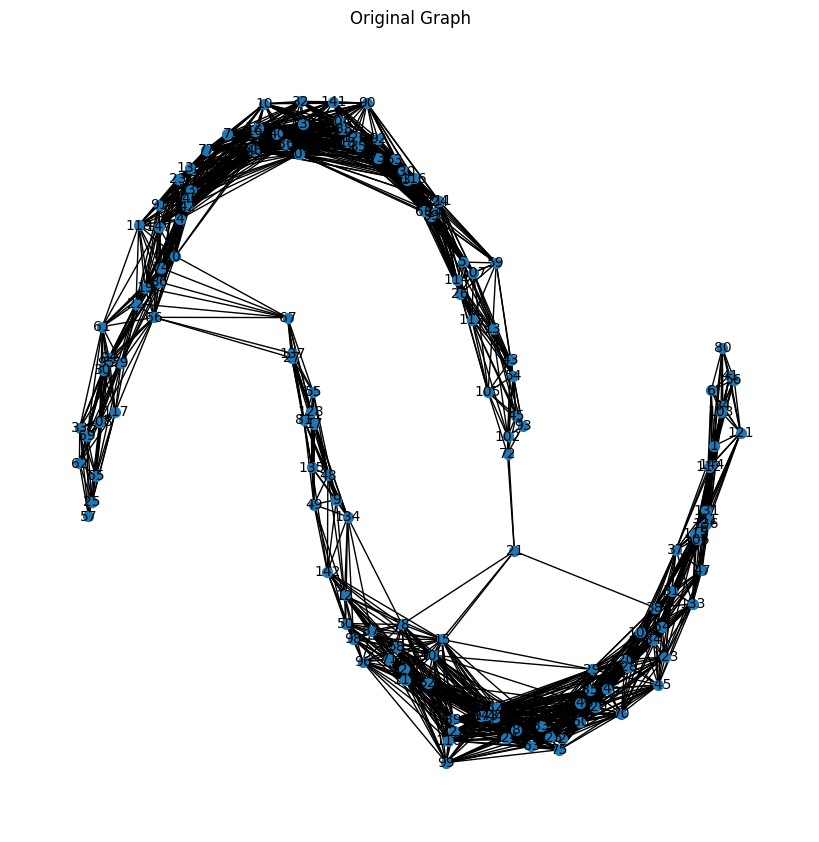

In [ ]:
# Perform spectral clustering on the datasets
dataset = 2  # Change this to select a different dataset 0-3
# Choose method for graph construction
graph_method = "eps"  # Set to knn or eps
k_or_epsilon = 0.5  # Set k for k-nearest neighbour graph or epsilon for epsilon-neighbourhood graph
weighted = True  # Set to True if you want weighted edges
n_clusters = 2  # Number of clusters to find
mode = "and" # Set to "and" or "or" for k-nearest neighbour graph




# No need to read the code below, just run it to perform spectral clustering and visualize the results
X = X_all[dataset * 150:(dataset+1)*150-1, :]
if graph_method == "knn":
    adjacency_matrix_final = knn_neighbourhood_graph(X_all[dataset * 150:(dataset+1)*150-1, :], k_or_epsilon, mode=mode, weighted=weighted)
elif graph_method == "eps":
    adjacency_matrix_final = eps_neighbourhood_graph(X_all[dataset * 150:(dataset+1)*150-1, :], k_or_epsilon, weighted=weighted)
else:
    raise ValueError("Unknown graph_method. Use 'knn' or 'eps'.")
plt.figure(figsize=(10, 10))
modes = ["RatioCut", "NormalizedCut"]
cluster_types = ["kmeans", "dendrogram"]
for i, mode in enumerate(modes):
    for j, cluster_type in enumerate(cluster_types):
        labels = spectral_clustering(adjacency_matrix_final, n_clusters, type=mode, cluster_method=cluster_type)
        plt.subplot(len(modes), len(cluster_types), i * len(cluster_types) + j + 1)
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
        plt.title(f"{mode} - {cluster_type}")
        plt.axis('equal')
plt.show()

# Show the original graph
plot_graph_from_adjacency_matrix(adjacency_matrix_final, X, title="Original Graph")